/home/michael/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: overflow encountered in ubyte_scalars


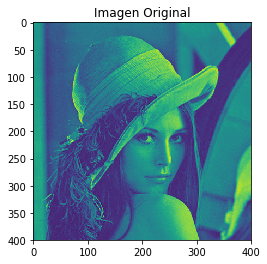

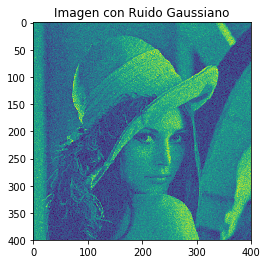

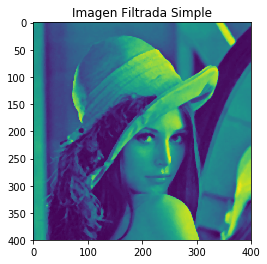

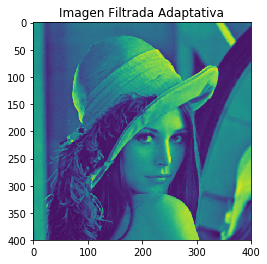

In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc
import os
import math

#Additive noise Gaussian
#Reference: https://stackoverflow.com/questions/22937589/how-to-add-noise-gaussian-salt-and-pepper-etc-to-image-in-python-with-opencv
def noisyGauss(image, mean, var):
    #row, col, ch = image.shape
    row, col = image.shape
    sigma = math.sqrt(var)
    #gauss = np.random.normal(mean, sigma, (row, col, ch))
    gauss = np.random.normal(mean, sigma, (row, col))
    #gauss = gauss.reshape(row, col, ch)
    gauss = gauss.reshape(row, col)
    noisy = image + gauss
    return noisy

def noisySyP(image):
    row, col, ch = image.shape
    s_vs_p = 0.5
    amount = 0.004
    out = np.copy(image)
    #Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    out[coords] = 1
    #Pepper mode
    num_pepper = np.ceil(amount * image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    out[coords] = 0
    return out

def localWindow(image, x, y, lk):
    top = 0
    bottom = 0
    an = 0
    al = 0
    alto, ancho = image.shape
    if y - lk >= 0:
        top = y - lk
    else:
        top = 0
    if y + lk < alto:
        bottom = y + lk
    else:
        bottom = alto - 1
    if x - lk >= 0:
        left = x - lk
    else:
        left = 0
    if x + lk < ancho:
        right = x + lk
    else:
        right = ancho - 1
    an = right - left + 1
    al = bottom - top + 1
    return top, left, al, an

def medianAdaptive(image, smax):
    alto, ancho = image.shape
    imageRes = image.copy()
    for x in range(ancho):
        for y in range(alto):
            newColor = None
            for lk in range(1, smax + 1):
                tp, le, al, an = localWindow(image, x, y, lk)
                subImage = image[tp : tp + al, le : le + an]
                zmin = np.min(subImage)
                zmax = np.max(subImage)
                zmed = np.median(subImage)
                a1 = zmed - zmin
                a2 = zmed - zmax
                if a1 > 0 and a2 < 0:
                    b1 = image[y][x] - zmin
                    b2 = image[y][x] - zmax
                    if b1 > 0 and b2 < 0:
                        newColor = image[y][x]
                        imageRes[y][x] = newColor
                        break
                    else:
                        newColor = zmed
                        imageRes[y][x] = zmed
                        break
            if newColor == None:
                newColor = image[y][x]
                imageRes[y][x] = newColor
    return imageRes

imagen = cv2.imread('Figures/Lenna.jpg')
imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
mean = 35
var = 200
imagenGauss = noisyGauss(imagen, mean, var)
imR = medianAdaptive(imagen, 5)
imR2 = cv2.medianBlur(imagen, 5)

#cv2.imshow('Imagen', imagen)
#cv2.imshow('Finale', imagenGauss)

# Salir con ESC
#while (1):
    #tecla = cv2.waitKey(5) & 0xFF
    #if tecla == 27:
        #break

#cv2.destroyAllWindows()

#cv2.imwrite('Lenna2.jpg', imagenGauss)
#cv2.imwrite('Lenna3.jpg', imR)

#print imagen
#print imagenGauss

plt.figure(1000)
plt.subplot(111)
plt.imshow(imagen)
plt.title('Imagen Original')
plt.show()
plt.subplot(111)
plt.imshow(imagenGauss)
plt.title('Imagen con Ruido Gaussiano')
plt.show()
plt.subplot(111)
plt.imshow(imR2)
plt.title('Imagen Filtrada Simple')
plt.show()
plt.subplot(111)
plt.imshow(imR)
plt.title('Imagen Filtrada Adaptativa')
plt.show()